<a href="https://colab.research.google.com/github/TamBui1706/DeepLearningCourse/blob/main/Week02/Week02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

#Import Data IMDB
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/IMDB Dataset.csv'

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Mounted at /content/drive


#Loading and Exploring the Dataset

First few entries in the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Balanced dataset class distribution:
sentiment
negative    5000
positive    5000
Name: count, dtype: int64

Training set shape: (5000, 2)
Testing set shape: (5000, 2)

<ipython-input-3-be698597e3bb>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('sentiment').apply(lambda x: x.sample(5000, random_state=42)).reset_index(drop=True)


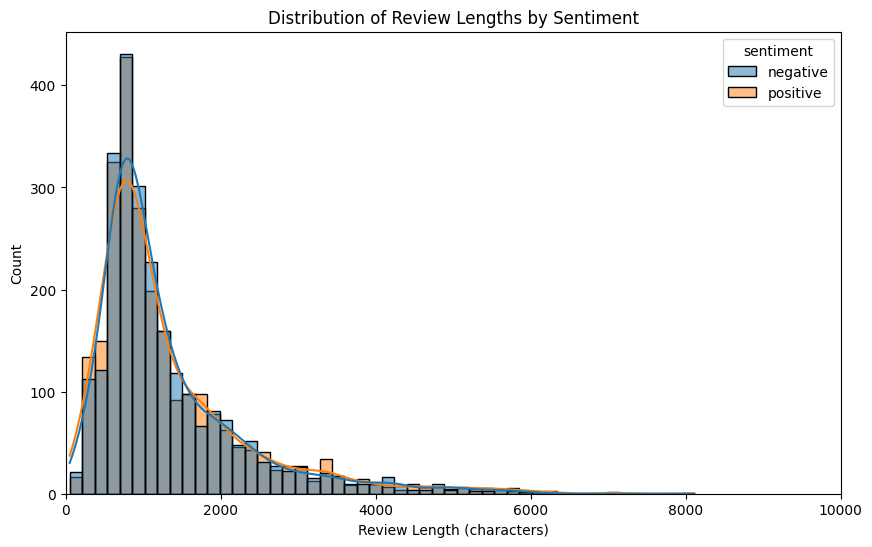

In [3]:
# Load CSV file
df = pd.read_csv(file_path)

# Check first few entries
print("First few entries in the dataset:")
print(df.head())

# Check dataset info
print("\nDataset information:")
df.info()

# Check class distribution
print("\nClass distribution:")
print(df['sentiment'].value_counts())

# Extract 5k samples for each class
df_balanced = df.groupby('sentiment').apply(lambda x: x.sample(5000, random_state=42)).reset_index(drop=True)
print("\nBalanced dataset class distribution:")
print(df_balanced['sentiment'].value_counts())

# Split into train and test sets
train_df, test_df = train_test_split(df_balanced, test_size=0.5, random_state=42, stratify=df_balanced['sentiment'])
print(f"\nTraining set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

# Plot the distribution of review lengths
train_df['review_length'] = train_df['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='review_length', hue='sentiment', bins=50, kde=True)
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Review Length (characters)')
plt.xlim(0, 10000)
plt.show()

#Text Preprocessing

In [4]:
# Download NLTK resources if not already available
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to reviews
print("Cleaning text data...")
train_df['cleaned_review'] = train_df['review'].apply(clean_text)
test_df['cleaned_review'] = test_df['review'].apply(clean_text)

# Show example of cleaned text
print("\nOriginal review:")
print(train_df['review'].iloc[0][:300], "...\n")
print("Cleaned review:")
print(train_df['cleaned_review'].iloc[0][:300], "...")

# Tokenize and pad sequences
max_features = 10000  # Top words to consider
max_len = 200  # Max sequence length

print("\nTokenizing and padding sequences...")
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df['cleaned_review'])

X_train = tokenizer.texts_to_sequences(train_df['cleaned_review'])
X_test = tokenizer.texts_to_sequences(test_df['cleaned_review'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentiment'])
y_test = label_encoder.transform(test_df['sentiment'])

print(f"\nVocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Cleaning text data...

Original review:
I bought this film at Blockbuster for $3.00, because it sounded interesting (a bit Ranma-esque, with the idea of someone dragging around a skeleton), because there was a cute girl in a mini-skirt on the back, and because there was a Restricted Viewing sticker on it. I thought it was going to be a sw ...

Cleaned review:
bought film blockbuster sounded interesting bit ranma esque idea someone dragging around skeleton cute girl mini skirt back restricted viewing sticker thought going sweet least sincere coming age story weird indie edge wrong watched wonder got restricted sticker since hardly foul language little vio ...

Tokenizing and padding sequences...

Vocabulary size: 34185
Training data shape: (5000, 200)
Testing data shape: (5000, 200)


#Model Building Function


In [5]:
def build_model(hidden_layers, neurons_per_layer, activation, dropout_rate,
                optimizer, learning_rate, embedding_dim=100):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(max_features, embedding_dim, input_length=max_len))

    # Hidden layers
    for i in range(hidden_layers):
        if i == 0:
            # First hidden layer
            model.add(Bidirectional(LSTM(neurons_per_layer, return_sequences=(hidden_layers > 1))))
        elif i == hidden_layers - 1:
            # Last hidden layer
            model.add(Bidirectional(LSTM(neurons_per_layer)))
        else:
            # Middle hidden layers
            model.add(Bidirectional(LSTM(neurons_per_layer, return_sequences=True)))

        # Add dropout after each LSTM layer
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    if optimizer.lower() == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer.lower() == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer.lower() == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define Hyperparameter Configurations

In [6]:
configs = [
    # Config 1: Baseline
    {
        'name': 'Baseline',
        'batch_size': 64,
        'learning_rate': 0.001,
        'hidden_layers': 1,
        'neurons_per_layer': 64,
        'activation': 'relu',
        'dropout_rate': 0.2,
        'optimizer': 'adam',
        'epochs': 5
    },
    # Config 2: Deeper Network
    {
        'name': 'Deeper Network',
        'batch_size': 64,
        'learning_rate': 0.001,
        'hidden_layers': 2,
        'neurons_per_layer': 64,
        'activation': 'relu',
        'dropout_rate': 0.2,
        'optimizer': 'adam',
        'epochs': 5
    },
    # Config 3: Different Optimizer
    {
        'name': 'RMSprop Optimizer',
        'batch_size': 64,
        'learning_rate': 0.001,
        'hidden_layers': 1,
        'neurons_per_layer': 64,
        'activation': 'relu',
        'dropout_rate': 0.2,
        'optimizer': 'rmsprop',
        'epochs': 5
    },
    # Config 4: Higher Learning Rate
    {
        'name': 'Higher Learning Rate',
        'batch_size': 64,
        'learning_rate': 0.01,
        'hidden_layers': 1,
        'neurons_per_layer': 64,
        'activation': 'relu',
        'dropout_rate': 0.2,
        'optimizer': 'adam',
        'epochs': 5
    },
    # Config 5: More Neurons
    {
        'name': 'More Neurons',
        'batch_size': 64,
        'learning_rate': 0.001,
        'hidden_layers': 1,
        'neurons_per_layer': 128,
        'activation': 'relu',
        'dropout_rate': 0.2,
        'optimizer': 'adam',
        'epochs': 5
    }
]

#Train and Evaluate Models


In [7]:
results = []

# For each configuration
for config in configs:
    config_results = []

    print(f"\nTraining with configuration: {config['name']}")
    print("Parameters:", {k: v for k, v in config.items() if k != 'name'})

    # Run 3 times for each configuration
    for run in range(3):
        print(f"  Run {run+1}/3")

        # Build model
        model = build_model(
            hidden_layers=config['hidden_layers'],
            neurons_per_layer=config['neurons_per_layer'],
            activation=config['activation'],
            dropout_rate=config['dropout_rate'],
            optimizer=config['optimizer'],
            learning_rate=config['learning_rate']
        )

        # Define early stopping
        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            restore_best_weights=True
        )

        # Train model
        history = model.fit(
            X_train, y_train,
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )

        # Evaluate model
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        config_results.append(accuracy)

        print(f"    Test accuracy: {accuracy:.4f}")

    # Calculate mean and standard deviation
    mean_accuracy = np.mean(config_results)
    std_accuracy = np.std(config_results)

    print(f"  Mean accuracy: {mean_accuracy:.4f}")
    print(f"  Standard deviation: {std_accuracy:.4f}")

    # Store results
    results.append({
        'config': config['name'],
        'accuracies': config_results,
        'mean': mean_accuracy,
        'std': std_accuracy
    })


Training with configuration: Baseline
Parameters: {'batch_size': 64, 'learning_rate': 0.001, 'hidden_layers': 1, 'neurons_per_layer': 64, 'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'adam', 'epochs': 5}
  Run 1/3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 579ms/step - accuracy: 0.5476 - loss: 0.6830 - val_accuracy: 0.7940 - val_loss: 0.5254
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 549ms/step - accuracy: 0.8521 - loss: 0.3842 - val_accuracy: 0.8490 - val_loss: 0.3696
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 548ms/step - accuracy: 0.9465 - loss: 0.1590 - val_accuracy: 0.8440 - val_loss: 0.4848
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 559ms/step - accuracy: 0.9776 - loss: 0.0676 - val_accuracy: 0.8200 - val_loss: 0.4956
    Test accuracy: 0.8444
  Run 2/3
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 584ms/step - accuracy: 0.5756 - loss: 0.6760 - val_accuracy: 0.8140 - val_loss: 0.4659
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 599ms/step - accuracy: 0.8506 - loss: 0.3774 - val_accuracy: 0.8390 - val_loss: 0.3907
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 550ms/step - accuracy: 0.9388 - loss: 0.1759 - val_accuracy: 0.8400 - val_loss: 0.5031
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 701ms/step - accuracy: 0.9714 - loss:

#Visualize Results


Summary of results:
          Configuration  Mean Accuracy  Std Accuracy
0              Baseline       0.837667      0.005118
1        Deeper Network       0.822467      0.006025
2     RMSprop Optimizer       0.831267      0.006512
3  Higher Learning Rate       0.807067      0.010508
4          More Neurons       0.821000      0.008553


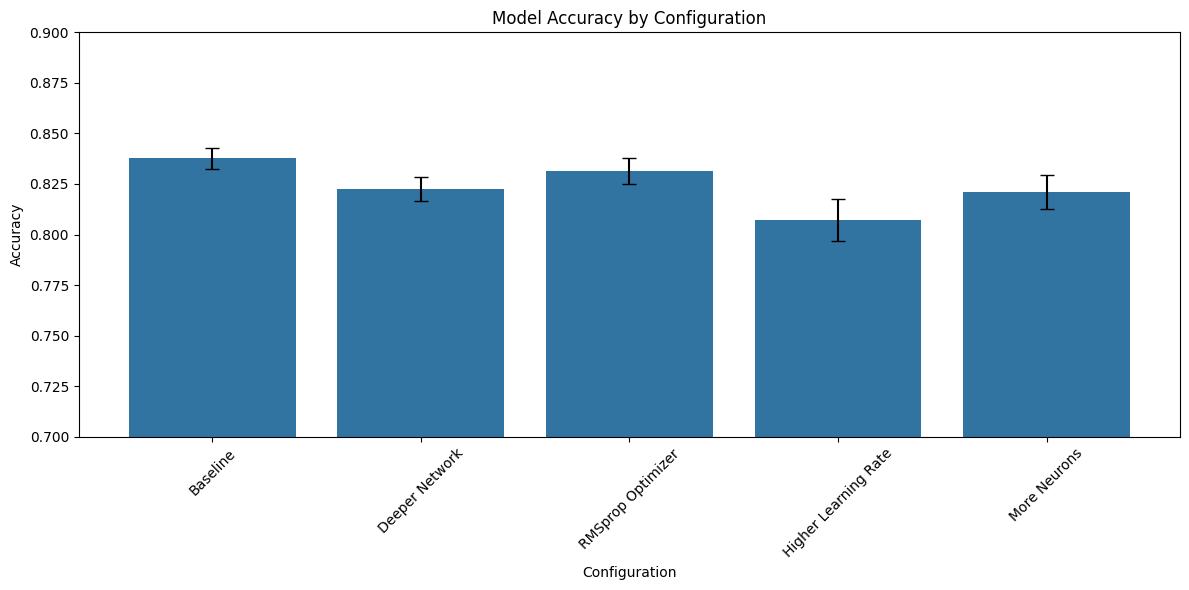

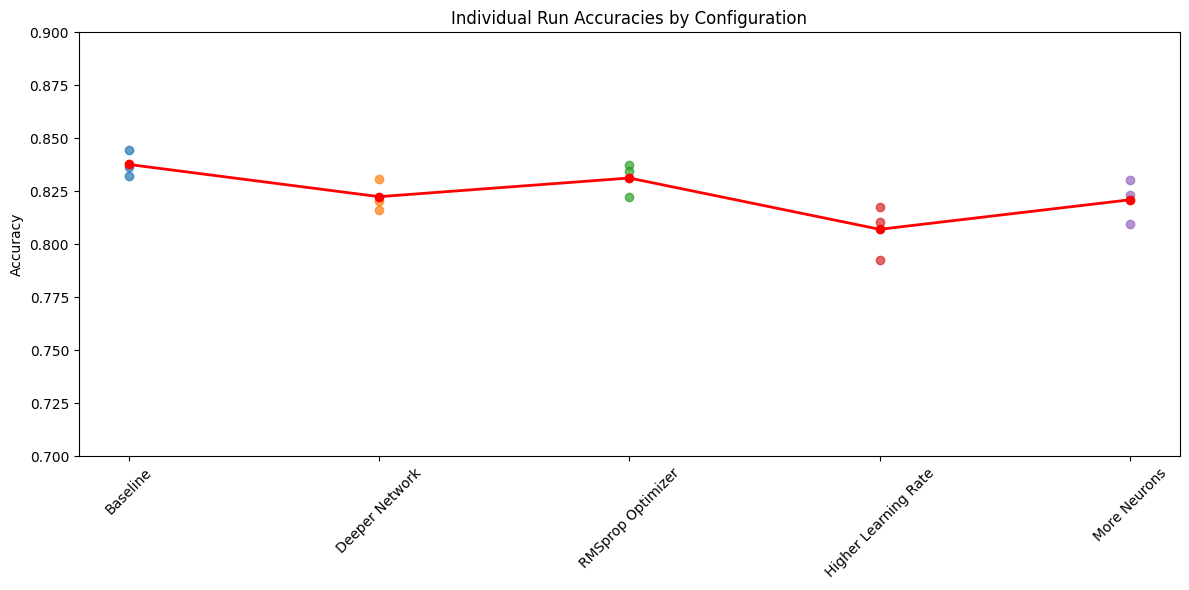

In [8]:
# Create a dataframe with the results
results_df = pd.DataFrame([
    {
        'Configuration': r['config'],
        'Mean Accuracy': r['mean'],
        'Std Accuracy': r['std']
    }
    for r in results
])

print("Summary of results:")
print(results_df)

# Plot bar chart with error bars
plt.figure(figsize=(12, 6))
sns.barplot(x='Configuration', y='Mean Accuracy', data=results_df)
plt.errorbar(
    x=range(len(results_df)),
    y=results_df['Mean Accuracy'],
    yerr=results_df['Std Accuracy'],
    fmt='none',
    color='black',
    capsize=5
)
plt.title('Model Accuracy by Configuration')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.9)  # Set y-axis limits for better visualization
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot individual runs for each configuration
plt.figure(figsize=(12, 6))
for i, r in enumerate(results):
    plt.scatter([r['config']]*3, r['accuracies'], alpha=0.7)

plt.plot(results_df['Configuration'], results_df['Mean Accuracy'], 'ro-', linewidth=2)
plt.title('Individual Run Accuracies by Configuration')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion Matrix

Best configuration: Baseline
Parameters: {'batch_size': 64, 'learning_rate': 0.001, 'hidden_layers': 1, 'neurons_per_layer': 64, 'activation': 'relu', 'dropout_rate': 0.2, 'optimizer': 'adam', 'epochs': 5}
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


79/79 ━━━━━━━━━━━━━━━━━━━━ 50s 566ms/step - accuracy: 0.5775 - loss: 0.6635
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 80s 544ms/step - accuracy: 0.8635 - loss: 0.3383
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 541ms/step - accuracy: 0.9484 - loss: 0.1608
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 549ms/step - accuracy: 0.9700 - loss: 0.0955
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 568ms/step - accuracy: 0.9730 - loss: 0.0919
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step


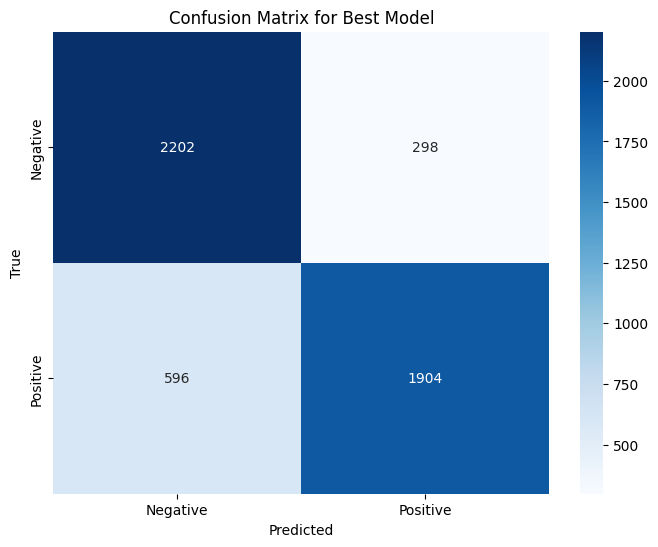

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.88      0.83      2500
    Positive       0.86      0.76      0.81      2500

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000



In [9]:
# Plot confusion matrix for the best configuration
best_config_idx = results_df['Mean Accuracy'].argmax()
best_config = configs[best_config_idx]

print(f"Best configuration: {best_config['name']}")
print("Parameters:", {k: v for k, v in best_config.items() if k != 'name'})

# Rebuild and train the best model
best_model = build_model(
    hidden_layers=best_config['hidden_layers'],
    neurons_per_layer=best_config['neurons_per_layer'],
    activation=best_config['activation'],
    dropout_rate=best_config['dropout_rate'],
    optimizer=best_config['optimizer'],
    learning_rate=best_config['learning_rate']
)

best_model.fit(
    X_train, y_train,
    batch_size=best_config['batch_size'],
    epochs=best_config['epochs'],
    verbose=1
)

# Predict on test set
y_pred = (best_model.predict(X_test) > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for Best Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))